Epoch 1/300


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0112 - val_loss: 0.0145
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0139
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0138
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0135
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0133
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0134
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0131
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0128
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0133
Epoch 10/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0125
Epoch 11/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0123
Epoch 12/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_l

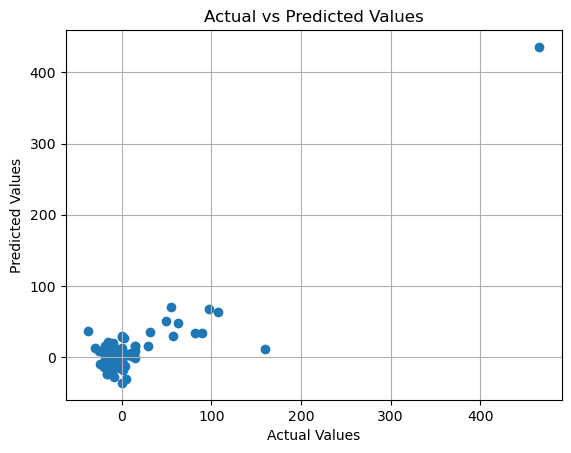

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])

# Creating lag features (shifted versions of the target 'HYB')
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Adding lag features for 'HYB' (target column)
data_lagged = create_lag_features(data, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()  # Drop NaN values created by lagging

# Set X and y again after creating lag features
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build an improved LSTM model with additional complexity
model_improved_v2 = Sequential()
model_improved_v2.add(LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(LSTM(100, activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(Dense(1))  # Output layer for regression

# Compile the model with a different optimizer and learning rate
optimizer_v2 = Adam(learning_rate=0.0005)
model_improved_v2.compile(optimizer=optimizer_v2, loss='mean_squared_error')

# Fit the model
history_improved_v2 = model_improved_v2.fit(X_train_lstm, y_train, epochs=300, batch_size=16, validation_data=(X_test_lstm, y_test))

# Predictions on the test set
predictions_scaled_v2 = model_improved_v2.predict(X_test_lstm)
predictions_v2 = scaler_y.inverse_transform(predictions_scaled_v2)  # Inverse transform predictions
y_test_rescaled_v2 = scaler_y.inverse_transform(y_test)  # Inverse transform y_test

# # Calculating Metrics on test set
# mse_v2 = mean_squared_error(y_test_rescaled_v2, predictions_v2)
# rmse_v2 = np.sqrt(mse_v2)
# mape_v2 = mean_absolute_percentage_error(y_test_rescaled_v2, predictions_v2)
# r2_v2 = r2_score(y_test_rescaled_v2, predictions_v2)

# print(f'Mean Squared Error (MSE): {mse_v2}')
# print(f'Root Mean Squared Error (RMSE): {rmse_v2}')
# print(f'Mean Absolute Percentage Error (MAPE): {mape_v2}')
# print(f'R-Squared (R²): {r2_v2}')

# Custom MAPE to handle zeros
def custom_mape(y_true, y_pred):
    mask = y_true != 0  # Mask to filter out zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculating Metrics on test set
mse_v2 = mean_squared_error(y_test_rescaled_v2, predictions_v2)
rmse_v2 = np.sqrt(mse_v2)
mape_v2 = custom_mape(y_test_rescaled_v2, predictions_v2)
r2_v2 = r2_score(y_test_rescaled_v2, predictions_v2)

print(f'Mean Squared Error (MSE): {mse_v2}')
print(f'Root Mean Squared Error (RMSE): {rmse_v2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_v2}')
print(f'R-Squared (R²): {r2_v2}')

# Export to Excel
output_df = pd.DataFrame({
    'Actual': y_test_rescaled_v2.flatten(),
    'Predicted': predictions_v2.flatten()
})
output_df.to_excel('actual_vs_predicted.xlsx', index=False)

# Scatter plot of actual vs predicted
plt.scatter(y_test_rescaled_v2, predictions_v2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()



Epoch 1/300


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0176 - val_loss: 0.0107
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0035
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0036
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 10/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 11/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 12/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_l

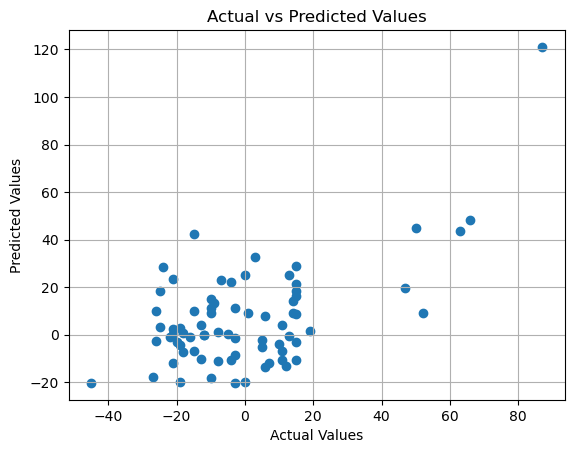

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import openpyxl

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])

# Creating lag features (shifted versions of the target 'HYB')
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Adding lag features for 'HYB' (target column)
data_lagged = create_lag_features(data, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()  # Drop NaN values created by lagging

# Set X and y again after creating lag features
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Sequential train-test split (80% training, 20% testing)
split_index = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Reshape X for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build an improved LSTM model with additional complexity
model_improved_v2 = Sequential()
model_improved_v2.add(LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(LSTM(100, activation='tanh'))
model_improved_v2.add(Dropout(0.3))
model_improved_v2.add(Dense(1))  # Output layer for regression

# Compile the model with a different optimizer and learning rate
optimizer_v2 = Adam(learning_rate=0.0005)
model_improved_v2.compile(optimizer=optimizer_v2, loss='mean_squared_error')

# Fit the model
history_improved_v2 = model_improved_v2.fit(X_train_lstm, y_train, epochs=300, batch_size=16, validation_data=(X_test_lstm, y_test))

# Predictions on the test set
predictions_scaled_v2 = model_improved_v2.predict(X_test_lstm)
predictions_v2 = scaler_y.inverse_transform(predictions_scaled_v2)  # Inverse transform predictions
y_test_rescaled_v2 = scaler_y.inverse_transform(y_test)  # Inverse transform y_test

# Custom MAPE to handle zeros
def custom_mape(y_true, y_pred):
    mask = y_true != 0  # Mask to filter out zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculating Metrics on test set
mse_v2 = mean_squared_error(y_test_rescaled_v2, predictions_v2)
rmse_v2 = np.sqrt(mse_v2)
mape_v2 = custom_mape(y_test_rescaled_v2, predictions_v2)
r2_v2 = r2_score(y_test_rescaled_v2, predictions_v2)

print(f'Mean Squared Error (MSE): {mse_v2}')
print(f'Root Mean Squared Error (RMSE): {rmse_v2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_v2}')
print(f'R-Squared (R²): {r2_v2}')

# Export to Excel
output_df = pd.DataFrame({
    'Actual': y_test_rescaled_v2.flatten(),
    'Predicted': predictions_v2.flatten()
})
output_df.to_excel('actual_vs_predicted.xlsx', index=False)

# Scatter plot of actual vs predicted
plt.scatter(y_test_rescaled_v2, predictions_v2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()
